In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from utils import get_data, train_val_test_split

YEAR_CUTOFFS = [1953, 1958, 1960]

This notebook is an exploration of the Naive model, introduced in the first notebook `n1_eda.ipynb`. The Naive model is a simple decomposition of the data into a trend and a seasonal components. The trend part is modelised and extrapolated with a Linear Regression model, and the seasonal part is averaged and applied on the forecast of the trend. It's a simple and intuitive model, but it can be a powerful solution, and a good benchmark from where to explore more sophisticated models.

# (1) Data

With a couple of new functions defined in `utils.py`, we retrieve the data and split it into train, validation and test sets. We choose to discard the first 4 years of the dataset, as they are a bit off from the seasonal effects of the last years, which are the ones that we want to predict.

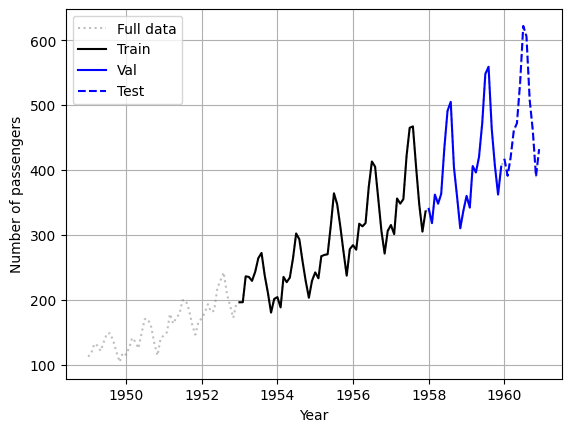

In [26]:
df = get_data()
train, val, test = train_val_test_split(df, YEAR_CUTOFFS)

plt.xlabel('Year')
plt.ylabel('Number of passengers')

plt.plot(df, color='gray', alpha=0.5, linestyle='dotted', label='Full data')
plt.plot(train, color='k', label='Train')
plt.plot(val, color='b', label='Val')
plt.plot(test, color='b', linestyle='dashed', label='Test')

plt.grid()
plt.legend()
plt.show()

# (2) Naive model

The Naive model is based on the function of `statsmodels` called `seasonal_decompose`. As shown below, the function extracts the trend with a rolling average, and identifies the seasonal component thanks to a parameter: `period`. We choose `two_sided=False` to avoid `NaN` in the last months of our training data. See how the trend line starts at 1954.

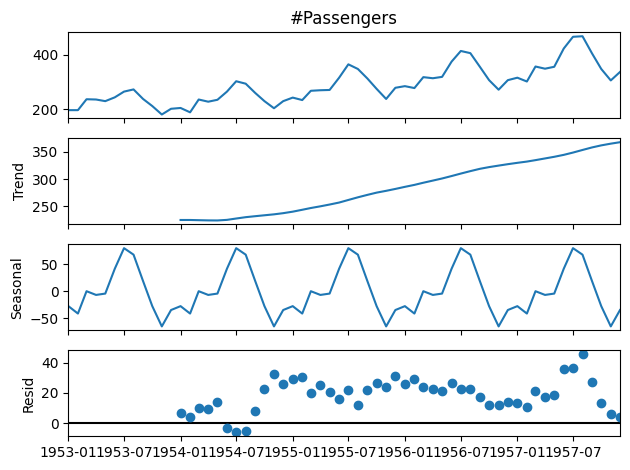

In [27]:
decompose = seasonal_decompose(train['#Passengers'], model='additive', period=12, two_sided=False)
decompose.plot()
plt.show()

Below another representation of the decomposition. Instead of the original and the trend and seasonal parts in different plots, we plot all lines overlapping. A couple of observations:
* As commented, the trend line (red) of `seasonal_decompose` is very close to the values we obtain with a rolling mean (dotted red).
* The trend and the seasonal components of `seasonal_decompose` added together are a good approximation to the train data. The differences are the residuals plotted above.

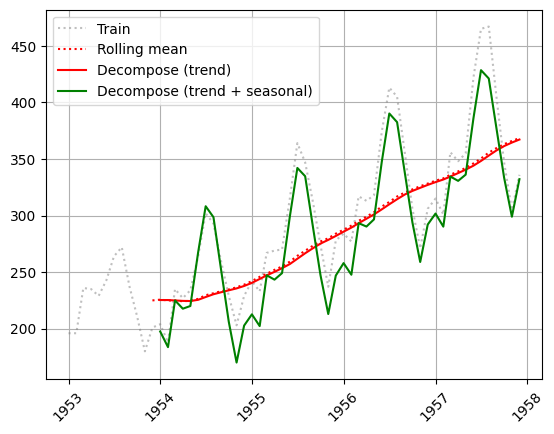

In [28]:
trend = decompose.trend.dropna()
seasonal = decompose.seasonal.dropna()

plt.plot(train, color='gray', linestyle='dotted', alpha=0.5, label='Train')
plt.plot(train.rolling(window=12).mean(), color='r', linestyle='dotted', label='Rolling mean')
plt.plot(trend, color='r', label='Decompose (trend)')
plt.plot(trend + seasonal, color='g', label='Decompose (trend + seasonal)')

plt.xticks(rotation = 45)

plt.legend()
plt.grid()
plt.show()

## (2.1) Trend forecast

To make a prediction of the trend line in the future years, we will fit a Linear Regression. We need a numerical `X` array instead of dates.

In [29]:
X = np.arange(len(trend.values)).reshape(-1, 1)
y = trend.values

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9873841781945386

Above the score of the Linear Regression, that is, the coefficient of determination $R^2$. As it is very close to 1, it indicates that the model does a notable job. We can get the coefficients of the model with the attributes `coef_` and `intercept_`.

In [30]:
print(reg.coef_)
print(reg.intercept_)

[3.33971767]
207.64597505668934


## (2.2) Full forecast

We extend our numerical `X` array to the number of points we need for the prediction, that is, `len(val)`. With this new array `X_pred`, we can get our prediction for the trend. To this, we can add the seasonal component of the `seasonal_decompose`.

In [31]:
X_pred = np.arange(X[-1][0] + 1, X[-1][0] + len(val) + 1).reshape(-1, 1)
y_pred = reg.predict(X_pred)
y_pred = pd.Series(data=y_pred, index=val.index)

model_naive = y_pred + seasonal[- len(val):].values

We can plot the results, with some metrics, to display that this Naive model is not so bad as one could think.

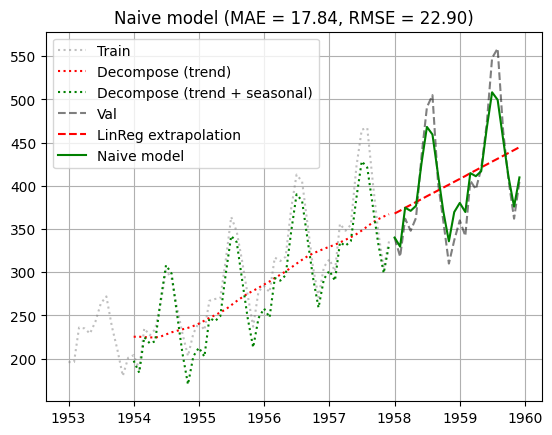

In [37]:
mae = mean_absolute_error(val, model_naive)
rmse = np.sqrt(mean_squared_error(val, model_naive))

plt.title(f'Naive model (MAE = {mae:.2f}, RMSE = {rmse:.2f})')

plt.plot(train, color='gray', linestyle='dotted', alpha=0.5, label='Train')
plt.plot(trend, color='r', linestyle='dotted', label='Decompose (trend)')
plt.plot(trend + seasonal, color='g', linestyle='dotted', label='Decompose (trend + seasonal)')

plt.plot(val, color='k', linestyle='dashed', alpha=0.5, label='Val')
plt.plot(y_pred, color='r', linestyle='dashed', label='LinReg extrapolation')
plt.plot(model_naive, color='g', label='Naive model')

plt.legend()
plt.grid()
plt.show()

But in the following notebooks we will explore other models that might be a bit more precise...